<a href="https://colab.research.google.com/github/hector6298/Deep-Learning-Collab-notebooks/blob/master/EEG_subject_classification_10_fold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import numpy as np
import tensorflow as tf
import os
import pandas as pd
import matplotlib.pyplot as plt

from google.colab import drive, files
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from tensorflow.keras.layers import Layer, Conv1D, MaxPool1D, Concatenate, BatchNormalization, AveragePooling1D, Input, LSTM, Flatten, Add, Dense
from tensorflow.keras import activations, Model
from sklearn import preprocessing
from sklearn.base import TransformerMixin
from sklearn.preprocessing import StandardScaler, MinMaxScaler

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
path = "/content/drive/My Drive/EEG"
files = os.listdir(path)

##Read a sample File

In [3]:
df = pd.read_csv("/content/drive/My Drive/EEG/F001-01G10.CSV")
df = df[128-int(df['timestamp'].iloc[0]-1):]
df

,timestamp,N,ch1,ch2,ch3,ch4,ch5,ch6,ch7,ch8,ch9,ch10,ch11,ch12,ch13,ch14,l1,l2,l3,l4,l5,l6,l7,l8,l9,l10,l11,l12,l13,l14,l15,l16,l17,l18,l19,l20
93,0.0,0.0,4459.999891,4719.999885,4676.410142,4263.076819,4473.846044,4751.281935,4753.846038,4364.102457,4683.589629,4277.435793,4568.205016,4231.794768,4278.461434,4228.717845,203.0,0.0,4.0,2.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,2.0,4.0,4.0,4.0,4.0,4.0,1667.0,1706.0,0.0
94,1.0,0.0,4458.461429,4721.025526,4678.974245,4263.076819,4471.794762,4748.717833,4751.794756,4365.640919,4702.051167,4263.076819,4571.281939,4241.538358,4284.102459,4230.769127,450.0,0.0,4.0,2.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,2.0,4.0,4.0,4.0,4.0,4.0,1665.0,1707.0,0.0
95,2.0,0.0,4458.974250,4717.435782,4678.461424,4261.538357,4465.640916,4751.794756,4750.256294,4357.435791,4697.948603,4263.589639,4570.256298,4239.999896,4284.102459,4236.922973,0.0,0.0,4.0,2.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,2.0,4.0,4.0,4.0,4.0,4.0,1666.0,1706.0,0.0
96,3.0,0.0,4461.025532,4716.410141,4675.384501,4262.563998,4468.717839,4747.179371,4748.717833,4355.897329,4687.179373,4257.948614,4569.743478,4233.333230,4280.512716,4230.256307,480.0,0.0,4.0,2.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,2.0,4.0,4.0,4.0,4.0,4.0,1666.0,1707.0,0.0
97,4.0,0.0,4461.538352,4718.461423,4673.333219,4262.051178,4471.281942,4733.333218,4744.102448,4353.846047,4676.410142,4252.820409,4570.769119,4232.820409,4278.974254,4219.487076,445.0,0.0,4.0,2.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,2.0,4.0,4.0,4.0,4.0,4.0,1665.0,1706.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42995,74.0,0.0,4468.205019,4785.128088,4722.051167,4236.922973,4481.538352,4751.281935,4766.666550,4350.769124,4687.179373,4261.538357,4520.512710,4263.589639,4354.358868,4266.153742,362.0,0.0,4.0,2.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,3.0,4.0,4.0,4.0,4.0,4.0,1663.0,1697.0,0.0
42996,75.0,0.0,4467.692198,4780.512704,4719.999885,4228.717845,4468.205019,4743.589628,4754.358858,4350.769124,4683.589629,4251.794768,4522.051171,4259.487075,4352.307586,4261.538357,365.0,0.0,4.0,2.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,3.0,4.0,4.0,4.0,4.0,4.0,1662.0,1698.0,0.0
42997,76.0,0.0,4468.205019,4781.538345,4716.922962,4232.307589,4454.358865,4740.512705,4748.205012,4356.410150,4681.025527,4250.769127,4522.563992,4256.922973,4347.179381,4261.538357,257.0,0.0,4.0,2.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,3.0,4.0,4.0,4.0,4.0,4.0,1663.0,1698.0,0.0
42998,77.0,0.0,4466.153737,4781.025524,4713.846039,4233.333230,4458.461429,4738.974243,4758.974243,4358.461432,4685.640911,4264.102460,4521.538351,4260.512716,4352.307586,4264.615280,364.0,0.0,4.0,2.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,3.0,4.0,4.0,4.0,4.0,4.0,1662.0,1699.0,0.0


In [4]:
df = df.iloc[:,2:16]
x = df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.338710,0.201868,0.651786,0.639821,0.456914,0.492135,0.464226,0.546697,0.549550,0.566596,0.663087,0.388175,0.180000,0.344961
1,0.290323,0.202124,0.659226,0.639821,0.448898,0.480899,0.457571,0.553531,0.630631,0.507400,0.671141,0.437018,0.195714,0.352713
2,0.306452,0.201228,0.657738,0.633110,0.424850,0.494382,0.452579,0.517084,0.612613,0.509514,0.668456,0.429306,0.195714,0.375969
3,0.370968,0.200972,0.648810,0.637584,0.436874,0.474157,0.447587,0.510251,0.565315,0.486258,0.667114,0.395887,0.185714,0.350775
4,0.387097,0.201484,0.642857,0.635347,0.446894,0.413483,0.432612,0.501139,0.518018,0.465116,0.669799,0.393316,0.181429,0.310078
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42902,0.596774,0.218114,0.784226,0.525727,0.486974,0.492135,0.505824,0.487472,0.565315,0.501057,0.538255,0.547558,0.391429,0.486434
42903,0.580645,0.216963,0.778274,0.489933,0.434870,0.458427,0.465890,0.487472,0.549550,0.460888,0.542282,0.526992,0.385714,0.468992
42904,0.596774,0.217219,0.769345,0.505593,0.380762,0.444944,0.445923,0.512528,0.538288,0.456660,0.543624,0.514139,0.371429,0.468992
42905,0.532258,0.217091,0.760417,0.510067,0.396794,0.438202,0.480865,0.521640,0.558559,0.511628,0.540940,0.532134,0.385714,0.480620



##Split All Subjects for 10 fold cross validation

In [5]:
def get_all_data(files, sample_rate, channels, shuffle=False):
  num_subjs = len(files)
  subjects = np.zeros((16834,sample_rate, channels), dtype=np.float32)
  labels = np.zeros((16834,), dtype=np.int32)
  j = 0
  subj_label = 0
  for file in files:
    df = pd.read_csv(f"{path}/{file}")
    df = df[128-int(df['timestamp'].iloc[0]-1):]
    df = df.iloc[:,2:16]
    subject_raw = df.values
    sample_rate = 129
    channels = 14
    splits = subject_raw.shape[0] // sample_rate
    idx = 0
    for i in range(splits):
      subjects[j] = subject_raw[idx*sample_rate:(idx+1)*sample_rate]
      labels[j] = subj_label
      j += 1
    subj_label += 1
  if shuffle:
    p = np.random.permutation(len(labels))
    subjects = subjects[p]
    labels = labels[p]
  return subjects, labels, num_subjs

In [6]:
sample_rate = 129
channels = 14
shuffle = True
subjects, labels, num_subjs = get_all_data(files, sample_rate, channels, shuffle)
skf = StratifiedKFold(n_splits=10)
X_dummy = np.zeros((16834,))



##train and test

In [7]:
!cp -r "/content/drive/My Drive/timeception" /content
from timeception import timeception

In [8]:
BATCH_SIZE=200
LEARNING_RATE=0.001

In [9]:
def make_ds(data, labels, batch_size=100):
  dataset_train = tf.data.Dataset.from_tensor_slices((data,labels))
  dataset_train = dataset_train.batch(batch_size).shuffle(10000).prefetch(tf.data.experimental.AUTOTUNE)
  return dataset_train

In [10]:
def init_timeception(learning_rate=0.001):
  model = timeception.construct_classifier((129,14),num_classes=51)
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])
  return model

In [11]:
def init_trivial_model(learning_rate=0.001):
  trivial_model = tf.keras.Sequential([
                                      Conv1D(filters=64,strides=1, kernel_size=3, activation='relu'),
                                      MaxPool1D(pool_size=3,strides=2, padding='same'),
                                      Conv1D(filters=64,strides=1, kernel_size=5,activation='relu'),
                                      Flatten(),
                                      Dense(51, activation='softmax')
  ])
  trivial_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])
  return trivial_model

In [26]:
def test(model,data, labels):
  preds_oh = []
  labels_oh = []
  predictions = model(data)
  preds_oh.append(predictions.numpy())
  oh = np.zeros((len(labels), num_subjs))
  oh[np.arange(len(labels)),labels] = 1
  labels_oh.append(oh) 
  preds_oh = np.array(preds_oh)
  labels_oh = np.array(labels_oh)
  return preds_oh, labels_oh

In [20]:
#Kilian Batzner https://stackoverflow.com/questions/50125844/how-to-standard-scale-a-3d-matrix

class NDMinMaxScaler(TransformerMixin):
    def __init__(self, **kwargs):
        self._scaler = MinMaxScaler(copy=True, **kwargs)
        self._orig_shape = None

    def fit(self, X, **kwargs):
        X = np.array(X)
        # Save the original shape to reshape the flattened X later
        # back to its original shape
        if len(X.shape) > 1:
            self._orig_shape = X.shape[1:]
        X = self._flatten(X)
        self._scaler.fit(X, **kwargs)
        return self

    def transform(self, X, **kwargs):
        X = np.array(X)
        X = self._flatten(X)
        X = self._scaler.transform(X, **kwargs)
        X = self._reshape(X)
        return X

    def _flatten(self, X):
        # Reshape X to <= 2 dimensions
        if len(X.shape) > 2:
            n_dims = np.prod(self._orig_shape)
            X = X.reshape(-1, n_dims)
        return X

    def _reshape(self, X):
        # Reshape X back to it's original shape
        if len(X.shape) >= 2:
            X = X.reshape(-1, *self._orig_shape)
        return X

In [27]:
def analysis(X, X_dummy, y, model_function, learning_rate, batch_size):
  histories = []
  tprs = []
  aucs = []
  mean_fpr = np.linspace(0, 1, 100)
  fig, ax = plt.subplots()
  
  for i,(train_index, test_index) in enumerate(skf.split(X_dummy, y)):
    print(f"Iteration {i}")
    print("1. Partitioning")
    min_max_scaler = NDMinMaxScaler()
    X_train, X_test = X[train_index], X[test_index]
    min_max_scaler.fit(X_train)
    X_train = min_max_scaler.transform(X_train)
    X_test = min_max_scaler.transform(X_test)
    y_train, y_test = y[train_index], y[test_index]
    print("2. Dataset creation")
    dataset_train = make_ds(X_train,y_train, batch_size)
    dataset_test = make_ds(X_test,y_test, batch_size)
    print("3. Training")
    model = model_function(learning_rate)
    model_history = model.fit(x=dataset_train,
                            epochs=5,
                            validation_data=dataset_test,
                            verbose=1,
                            )
    histories.append(model_history)
    print("4. ROC")
    preds_oh, labels_oh = test(model, X_test, y_test)
    fpr, tpr, thresholds = metrics.roc_curve(labels_oh.ravel(), preds_oh.ravel())
    ax.plot(fpr, tpr, alpha=0.3, color='green',lw=2, label=f"ROC fold {i}")
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    roc_auc = metrics.auc(fpr, tpr)
    tprs.append(interp_tpr)
    aucs.append(roc_auc)
    
  ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
          label='Chance', alpha=.8)
  mean_tpr = np.mean(tprs, axis=0)
  mean_tpr[-1] = 1.0
  mean_auc = metrics.auc(mean_fpr, mean_tpr)
  std_auc = np.std(aucs)
  print("5. All ROC")
  ax.plot(mean_fpr, mean_tpr, color='b',
          label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
          lw=2, alpha=.8)

  std_tpr = np.std(tprs, axis=0)
  tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
  tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
  ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                  label=r'$\pm$ 1 std. dev.')

  ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
        title="Receiver operating characteristic example")
  ax.legend(loc="lower right")
  plt.show()
  return histories

In [14]:
test1_args = {
    'X' : subjects,
    'X_dummy' : X_dummy,
    'y' : labels,
    'model_function' : init_timeception,
    'learning_rate' : LEARNING_RATE,
    'batch_size' : BATCH_SIZE
}

test2_args = {
    'X' : subjects,
    'X_dummy' : X_dummy,
    'y' : labels,
    'model_function' : init_trivial_model,
    'learning_rate' : LEARNING_RATE,
    'batch_size' : BATCH_SIZE
}

Iteration 0
1. Partitioning
2. Dataset creation
3. Training
Epoch 1/60
76/76 [==============================] - 150s 2s/step - loss: 3.6019 - accuracy: 0.1183 - val_loss: 3.9327 - val_accuracy: 0.0202
Epoch 2/60
76/76 [==============================] - 147s 2s/step - loss: 3.0291 - accuracy: 0.4509 - val_loss: 3.9922 - val_accuracy: 0.0196
Epoch 3/60
76/76 [==============================] - 148s 2s/step - loss: 2.6309 - accuracy: 0.6992 - val_loss: 4.2179 - val_accuracy: 0.0196
Epoch 4/60
76/76 [==============================] - 147s 2s/step - loss: 2.3050 - accuracy: 0.7675 - val_loss: 4.3121 - val_accuracy: 0.0190
Epoch 5/60
76/76 [==============================] - 148s 2s/step - loss: 2.1543 - accuracy: 0.7702 - val_loss: 4.4519 - val_accuracy: 0.0196
Epoch 6/60
76/76 [==============================] - 147s 2s/step - loss: 1.8099 - accuracy: 0.8865 - val_loss: 4.2916 - val_accuracy: 0.0190
Epoch 7/60
76/76 [==============================] - 148s 2s/step - loss: 1.5568 - accuracy: 0.

KeyboardInterrupt: ignored

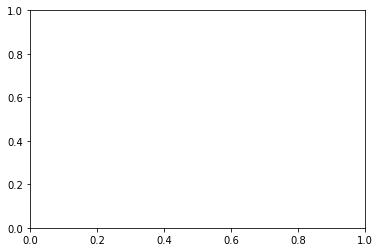

In [22]:
histories = analysis(**test1_args)

Iteration 0
1. Partitioning
2. Dataset creation
3. Training
Epoch 1/5
76/76 [==============================] - 6s 82ms/step - loss: 1.2489 - accuracy: 0.7824 - val_loss: 0.0344 - val_accuracy: 1.0000
Epoch 2/5
76/76 [==============================] - 6s 81ms/step - loss: 0.0144 - accuracy: 1.0000 - val_loss: 0.0068 - val_accuracy: 1.0000
Epoch 3/5
76/76 [==============================] - 6s 82ms/step - loss: 0.0047 - accuracy: 1.0000 - val_loss: 0.0032 - val_accuracy: 1.0000
Epoch 4/5
76/76 [==============================] - 6s 84ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.0020 - val_accuracy: 1.0000
Epoch 5/5
76/76 [==============================] - 6s 81ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.0013 - val_accuracy: 1.0000
4. ROC
Iteration 1
1. Partitioning
2. Dataset creation
3. Training
Epoch 1/5
76/76 [==============================] - 6s 81ms/step - loss: 1.2507 - accuracy: 0.7899 - val_loss: 0.0347 - val_accuracy: 1.0000
Epoch 2/5
76/76 [================

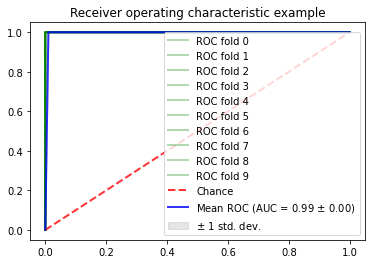

In [28]:
trivial_histories = analysis(**test2_args)

In [ ]:
def plot_metrics(model_history):

  loss = model_history.history['loss']
  val_loss = model_history.history['val_loss']

  iou = model_history.history['accuracy']
  val_iou = model_history.history['val_accuracy']
  epochs = range(60)
  fig, axs = plt.subplots(2)

  axs[0].plot(epochs, loss, 'r', label='Training loss')
  axs[0].plot(epochs, val_loss, 'bo', label='Validation loss')


  axs[1].plot(epochs, iou, 'r', label='Training acc')
  axs[1].plot(epochs, val_iou, 'bo', label='Validation acc')

  plt.legend()
  plt.show()


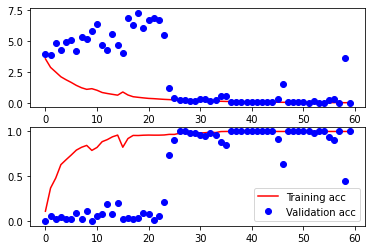

In [ ]:
plot_metrics(model_history)

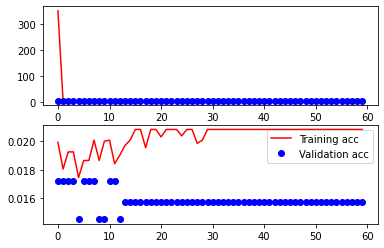

In [ ]:
plot_metrics(trivial_model_history)